In [1]:
from fastbook import *

In [2]:
from fastai.vision.widgets import *

In [3]:
import os


In [4]:
??search_images_bing

In [5]:
import os

In [6]:
??os

In [7]:
key = os.environ.get('AZURE_SEARCH_KEY', 'a4dc0d76f21941458a1ba2e2669a1800')

In [8]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [9]:
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [10]:
dest = 'images/grimzy.jpg'
download_url(ims[0], dest)

In [11]:
??download_url

In [12]:
??results.attrgot

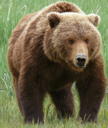

In [13]:
im = Image.open(dest)
im.to_thumb(128,128)

In [14]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [15]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [16]:
fns = get_image_files(path)
fns

(#381) [Path('bears/black/00000047.png'),Path('bears/black/00000117.jpg'),Path('bears/black/00000058.jpg'),Path('bears/black/00000076.jpg'),Path('bears/black/00000123.jpg'),Path('bears/black/00000046.jpg'),Path('bears/black/00000087.jpg'),Path('bears/black/00000149.JPG'),Path('bears/black/00000002.png'),Path('bears/black/00000116.jpg')...]

In [17]:
??get_image_files

In [18]:
failed=verify_images(fns)

In [19]:
failed

(#0) []

In [20]:
??verify_images

In [21]:
failed.map(Path.unlink);

In [22]:
??Path.unlink

In [23]:
??DataBlock

In [24]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [25]:
dls=bears.dataloaders(path)

/home/niyazi/anaconda3/envs/fastbook/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


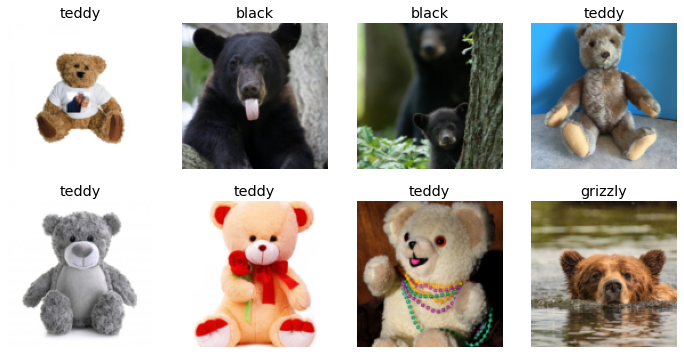

In [26]:
dls.valid.show_batch(max_n=8,nrows=2)

In [27]:
??bears.new

### "new" method creates a new datablock from the previous one. ResizeMethod is obvious.

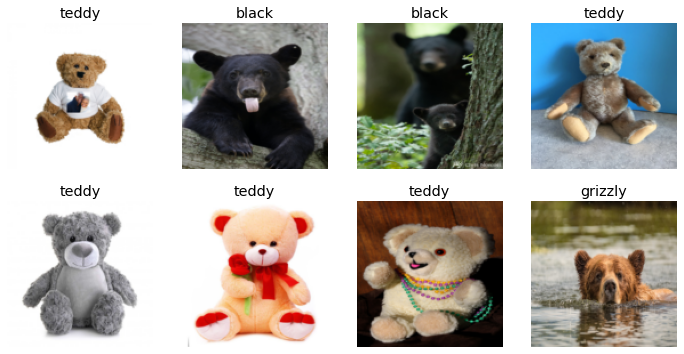

In [28]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=2)

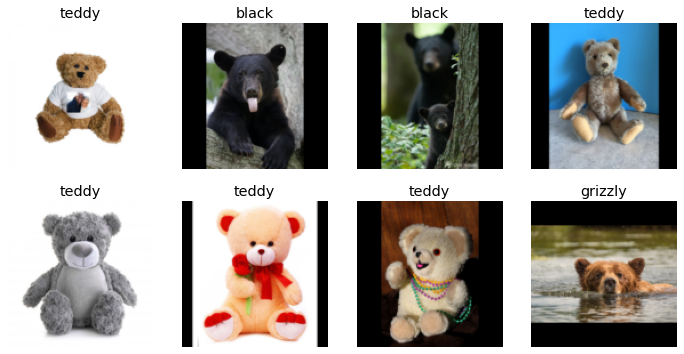

In [29]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=2)

### some images are looks squished below. Why? I added ratio. I think that is the reason.

In [30]:
??RandomResizedCrop

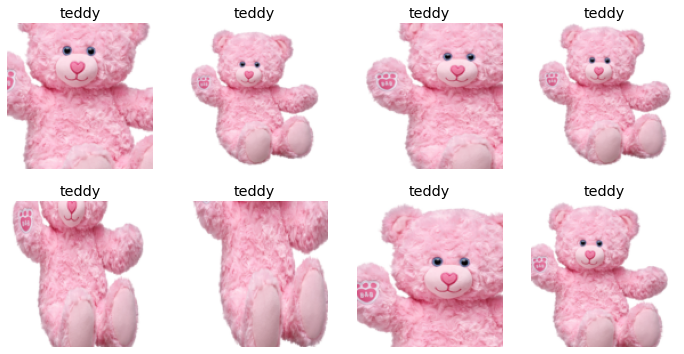

In [31]:
bears = bears.new(item_tfms=RandomResizedCrop(128,ratio=(.5,3), min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

/home/niyazi/anaconda3/envs/fastbook/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


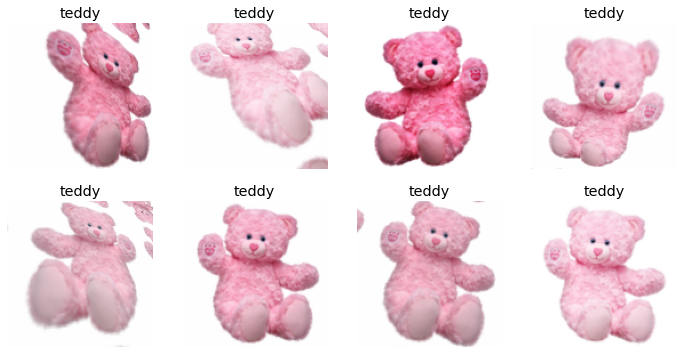

In [32]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [33]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/niyazi/anaconda3/envs/fastbook/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,error_rate,time
0,1.730910,0.290877,0.118421,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.518409,0.094677,0.039474,00:07
1,0.387960,0.146356,0.052632,00:07
2,0.331235,0.121952,0.052632,00:07


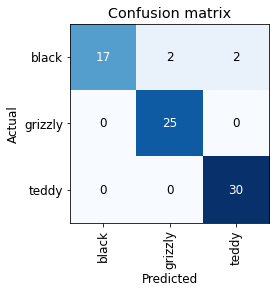

In [34]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

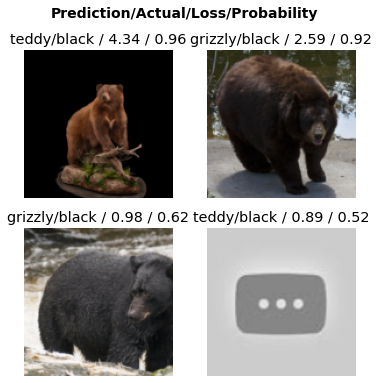

In [35]:
interp.plot_top_losses(4, nrows=0)

In [36]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [37]:
#hide
#for idx in cleaner.delete(): cleaner.fns[idx].unlink()
#for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [38]:
learn.export()

In [39]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [40]:
learn_inf = load_learner(path/'export.pkl')

#### First--> predicted, second--> predicted tensor, third--> probabilities

In [41]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([2.9604e-05, 9.9989e-01, 7.8898e-05]))

In [42]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [58]:
upload_button=widgets.FileUpload()
upload_button

FileUpload(value={}, description='Upload')

In [ ]:
# if you want to fake it data then
# btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [59]:
img = PILImage.create(upload_button.data[-1])

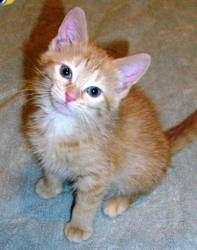

In [60]:
img

In [61]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [62]:
pred,pred_idx,probs = learn_inf.predict(img)

In [63]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: teddy; Probability: 0.9914')

In [66]:
btn_run = widgets.Button(description='Classify')
btn_run


Button(description='Classify', style=ButtonStyle())

In [67]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [68]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [69]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [70]:
#hide
#!pip install voila
#!jupyter serverextension enable --sys-prefix voila 

     |████████████████████████████████| 1.6 MB 701 kB/s eta 0:00:01
     |████████████████████████████████| 389 kB 38.6 MB/s eta 0:00:01
     |████████████████████████████████| 551 kB 40 kB/s eta 0:00:0101
     |████████████████████████████████| 68 kB 5.1 MB/s  eta 0:00:01
     |████████████████████████████████| 427 kB 34 kB/s eta 0:00:0101
     |████████████████████████████████| 75 kB 241 kB/s eta 0:00:011


  Attempting uninstall: tornado
    Found existing installation: tornado 6.0.4
    Uninstalling tornado-6.0.4:
      Successfully uninstalled tornado-6.0.4
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbdev 1.1.14 requires nbconvert<6, but you have nbconvert 6.1.0 which is incompatible.
Enabling: voila
- Writing config: /home/niyazi/anaconda3/envs/fastbook/etc/jupyter
    - Validating...
      voila 0.2.10 OK
